In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlretrieve
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML

np.random.seed(13)

pd.set_option('display.max_columns', None) # to display all columns

# DATA ACQUISITION

We have uploaded the CSVs as a release of the Github repository so that it's possible to download them if they aren't locally available.

In [3]:
csv_names = ["movies.csv", "ratings.csv", "genome-scores.csv", "genome-tags.csv", "links.csv", "tags.csv"]
datasets_names = [i[:-4].replace("-", "_") for i in csv_names]

local_csv_dir = os.path.join("datasets", "datasets-ml-25m")
remote_csv_dir = "http://github.com/MickPerl/DataAnalyticsProject/releases/download/datasets/"

In [4]:
if not os.path.exists(os.path.join("datasets", "datasets-ml-25m")):
    os.makedirs(os.path.join("datasets", "datasets-ml-25m"))

In [5]:
def name(dataset_name) :
    return "_".join(['df', dataset_name])

The following code tries to read the csv file given the local path: in case of failure, it download the file from the remote path to the local path so that it can successfully read them.

In [6]:
for i in range(len(csv_names)):
    local_csv_path = os.path.join(local_csv_dir, csv_names[i])
    
    '''
    nella versione da consegnare si utilizzerà la funzione name(), così da non occupare memoria con copie di DataFrame
    '''
    try : 
        # if the path exists as well as the file, read directly  
        globals()[datasets_names[i]] = pd.read_csv(local_csv_path)     
        # globals()[name(datasets_names[i])] = pd.read_csv(path)

    except FileNotFoundError:
        print(f"Download in progress of {csv_names[i]}")
        remote_csv_path = os.path.join(remote_csv_dir, csv_names[i])
        file, _ = urlretrieve(url = remote_csv_path, filename=local_csv_path)
        globals()[datasets_names[i]] = pd.read_csv(file)
        # globals()[name(datasets_names[i])] = pd.read_csv(file[0])

In [7]:
# prima della consegna, eliminare queste righe
df_movies = movies.copy()
df_ratings = ratings.copy()
df_links = links.copy()
df_genome_scores = genome_scores.copy()
df_genome_tags = genome_tags.copy()
df_tags = tags.copy()

# DATA PREPROCESSING

## Data manipulation

Within this section, we go through the `DataFrame`'s obtained by executing the previous data acquisition: we highlight their peculiarities and join them in order to end up getting the complete dataset.

### df_movies

In [8]:
output = df_movies.head().style.set_caption("df_movies")._repr_html_()
display(HTML(output))

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


The `df_movies` DataFrame contains the following information with regard to $62423$ films.

In [9]:
len(df_movies)

62423

Each film has a different title, therefore we have considered it as a negligible information: however, before dropping the corresponding column `title`, we have extracted from it the **year** of each film which could be a relevant feature.

In [10]:
title_trimmed = df_movies['title'].str.strip()
df_movies["year"] = title_trimmed.str.slice(start=-5, stop=-1)

df_movies["title_length"] = df_movies['title'].str.len()
df_movies.drop('title', inplace=True, axis=1)

In [11]:
# descrivere questa riga
df_movies.iloc[:,2] = pd.to_numeric(df_movies.iloc[:,2], errors='coerce')

For each film, the dataset `df_movies` stores its genres by a pipe-separated list:

In [12]:
df_movies.genres.head()

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

Consequently, we have decided to add one column for each possible genre: if the film belongs to a certain genre, the corresponding cell will contain `1`, `0` otherwise.
To do that, first of all we instantiate the class `MultiLabelBinarizer` from the `preprocessing` module of the `sklearn` library: its method `fit_transform` takes as input the set of labels for each samples and outputs a matrix of shape (# samples, # unique labels) such that each cell has `1` if the corresponding film belongs to the corresponding genre, `0` otherwise.\
Then, we convert this matrix to a `DataFrame` object whose columns are the genres' name; eventually, the result is joined with `df_movies` DataFrame.

In [13]:
mlb = MultiLabelBinarizer()
df_movies = df_movies.join(pd.DataFrame(
                mlb.fit_transform(df_movies.pop('genres').str.split('|')),
                index=df_movies.index,
                columns=mlb.classes_))
        
df_movies.head()

,movieId,year,title_length,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1995.0,16,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,1995.0,14,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,1995.0,23,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,1995.0,24,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,1995.0,34,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### df_genome_tags and df_genome_scores

`df_genome_scores` contains tag relevance scores for movies.\
The set of relevances regarding a film is its *genome*: thus, the genome encodes how strongly movies exhibit particular properties represented by tags (atmospheric, thought-provoking, realistic, etc.).  

In [14]:
output = df_genome_scores.head().style.set_caption('First 5 rows of df_genome_scores')._repr_html_()
display(HTML(output))

,movieId,tagId,relevance
0,1,1,0.028750
1,1,2,0.023750
2,1,3,0.062500
3,1,4,0.075750
4,1,5,0.140750


ci sono 15584448 rating degli utenti

In [15]:
len(df_genome_scores)

15584448

In particular, only $13816$ films out of $62423$ have a genome: the remaining 48607 aren't characterized by any tag.

In [16]:
len(df_genome_scores.groupby("movieId"))

13816

The structure of `df_genome_scores` is a dense matrix: each movie within it has a value for every tag in the genome as it's possible to prove through grouping by `movieId` value and seeing that the number of unique tags is the same over all films.

In [17]:
print(*df_genome_scores.groupby("movieId").count().tagId.unique())

1128


to add

In [18]:
len(df_genome_tags)

1128

We can continue merging `df_genome_scores` with `df_genome_tags` which explicits every tag.

In [19]:
def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

display_side_by_side([df_genome_scores.head(), df_genome_tags.head()], ['df_genome_scores', 'df_genome_tags'])

In [20]:
df_genome = pd.merge(df_genome_scores, df_genome_tags, on="tagId", how="left")

After that, we want to manipulate the `df_genome` DataFrame in order to relate every film to its genome. 

In [21]:
df_genome = df_genome.pivot(index='movieId', columns='tag', values="relevance")
df_genome.head()

tag,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,3d,70mm,80s,9/11,aardman,aardman studios,abortion,absurd,action,action packed,adaptation,adapted from:book,adapted from:comic,adapted from:game,addiction,adolescence,adoption,adultery,adventure,affectionate,afi 100,afi 100 (laughs),afi 100 (movie quotes),africa,afterlife,aging,aids,airplane,airport,alaska,alcatraz,alcoholism,alien,alien invasion,aliens,allegory,almodovar,alone in the world,alter ego,alternate endings,alternate history,alternate reality,alternate universe,amazing cinematography,amazing photography,american civil war,amnesia,amy smart,android(s)/cyborg(s),androids,animal movie,animals,animated,animation,anime,antarctica,anti-hero,anti-semitism,anti-war,apocalypse,archaeology,argentina,arms dealer,arnold,art,art house,artificial intelligence,artist,artistic,artsy,assassin,assassination,assassins,astronauts,atheism,atmospheric,australia,australian,author:alan moore,author:neil gaiman,autism,aviation,awesome,awesome soundtrack,awful,bad,bad acting,bad cgi,bad ending,bad plot,bad science,bad script,bad sequel,ballet,bank robbery,baseball,based on a book,based on a comic,based on a play,based on a true story,based on a tv show,based on a video game,based on book,based on comic,based on true story,basketball,batman,bdsm,beatles,beautiful,beautiful scenery,beautifully filmed,beauty pageant,beer,berlin,best of 2005,best war films,betrayal,better than expected,better than the american version,biblical,big budget,biographical,biography,biopic,birds,biting,bittersweet,bizarre,black and white,black comedy,blaxploitation,bleak,blindness,blood,bloody,boarding school,boat,bollywood,bombs,bond,book,book was better,books,boring,boring!,boston,bowling,boxing,brainwashing,brazil,breathtaking,brilliant,british,british comedy,broadway,brothers,brutal,brutality,buddy movie,bullshit history,bullying,business,c.s. lewis,california,camp,campy,canada,cancer,cannibalism,caper,capitalism,car chase,carrie-anne moss,cars,cartoon,casino,catastrophe,cathartic,catholicism,censorship,cerebral,cgi,character study,chase,cheating,cheerleading,cheesy,chess,chicago,chick flick,child abuse,childhood,children,china,chocolate,chris tucker,christian,christianity,christmas,cia,cinematography,circus,civil war,classic,classic car,classical music,claustrophobic,claymation,clever,clones,cloning,clowns,coen bros,coen brothers,cold war,college,colonialism,colourful,comedy,comic,comic book,comic book adaption,comics,coming of age,coming-of-age,communism,compassionate,competition,complex,complex characters,complicated,complicated plot,computer animation,computer game,computers,con artists,con men,confrontational,confusing,conspiracy,conspiracy theory,controversial,cooking,cool,corny,corporate america,corruption,costume drama,courage,court,courtroom,courtroom drama,crappy sequel,crazy,creativity,creepy,crime,crime gone awry,criterion,cross dressing,crude humor,cuba,cult,cult classic,cult film,culture clash,cute,cute!,cyberpunk,cyborgs,cynical,dance,dancing,dark,dark comedy,dark fantasy,dark hero,dark humor,dc comics,deadpan,death,death penalty,demons,depp & burton,depressing,depression,desert,destiny,detective,devil,dialogue,dialogue driven,dinosaurs,directorial debut,disability,disappointing,disaster,disney,disney animated feature,distopia,disturbing,divorce,doctors,documentary,dog,dogs,dolphins,downbeat,dr. seuss,dragon,dragons,drama,dramatic,dreamlike,dreams,dreamworks,drinking,drug abuse,drug addiction,drugs,dumb,dumb but funny,dynamic cgi action,dysfunctional family,dystopia,dystopic future,earnest,easily confused with other movie(s) (title),east germany,eccentricity,ecology,educational,eerie,effects,egypt,emma watson,emotional,end of the world,england,enigmatic,ennio morricone,enormously long battle scene,ensemble cast,entertaining,entirely dialogue,environment,environmental,epic,erotic,espionage,ethnic conflict,evolution,excellent,excellent script,exceptional acting,exciting,

We can merge the result with `df_movies`.

In [22]:
df = pd.merge(df_movies, df_genome, on="movieId", how = "left")
df.head()

,movieId,year,title_length,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,3d,70mm,80s,9/11,aardman,aardman studios,abortion,absurd,action,action packed,adaptation,adapted from:book,adapted from:comic,adapted from:game,addiction,adolescence,adoption,adultery,adventure,affectionate,afi 100,afi 100 (laughs),afi 100 (movie quotes),africa,afterlife,aging,aids,airplane,airport,alaska,alcatraz,alcoholism,alien,alien invasion,aliens,allegory,almodovar,alone in the world,alter ego,alternate endings,alternate history,alternate reality,alternate universe,amazing cinematography,amazing photography,american civil war,amnesia,amy smart,android(s)/cyborg(s),androids,animal movie,animals,animated,animation,anime,antarctica,anti-hero,anti-semitism,anti-war,apocalypse,archaeology,argentina,arms dealer,arnold,art,art house,artificial intelligence,artist,artistic,artsy,assassin,assassination,assassins,astronauts,atheism,atmospheric,australia,australian,author:alan moore,author:neil gaiman,autism,aviation,awesome,awesome soundtrack,awful,bad,bad acting,bad cgi,bad ending,bad plot,bad science,bad script,bad sequel,ballet,bank robbery,baseball,based on a book,based on a comic,based on a play,based on a true story,based on a tv show,based on a video game,based on book,based on comic,based on true story,basketball,batman,bdsm,beatles,beautiful,beautiful scenery,beautifully filmed,beauty pageant,beer,berlin,best of 2005,best war films,betrayal,better than expected,better than the american version,biblical,big budget,biographical,biography,biopic,birds,biting,bittersweet,bizarre,black and white,black comedy,blaxploitation,bleak,blindness,blood,bloody,boarding school,boat,bollywood,bombs,bond,book,book was better,books,boring,boring!,boston,bowling,boxing,brainwashing,brazil,breathtaking,brilliant,british,british comedy,broadway,brothers,brutal,brutality,buddy movie,bullshit history,bullying,business,c.s. lewis,california,camp,campy,canada,cancer,cannibalism,caper,capitalism,car chase,carrie-anne moss,cars,cartoon,casino,catastrophe,cathartic,catholicism,censorship,cerebral,cgi,character study,chase,cheating,cheerleading,cheesy,chess,chicago,chick flick,child abuse,childhood,children,china,chocolate,chris tucker,christian,christianity,christmas,cia,cinematography,circus,civil war,classic,classic car,classical music,claustrophobic,claymation,clever,clones,cloning,clowns,coen bros,coen brothers,cold war,college,colonialism,colourful,comedy,comic,comic book,comic book adaption,comics,coming of age,coming-of-age,communism,compassionate,competition,complex,complex characters,complicated,complicated plot,computer animation,computer game,computers,con artists,con men,confrontational,confusing,conspiracy,conspiracy theory,controversial,cooking,cool,corny,corporate america,corruption,costume drama,courage,court,courtroom,courtroom drama,crappy sequel,crazy,creativity,creepy,crime,crime gone awry,criterion,cross dressing,crude humor,cuba,cult,cult classic,cult film,culture clash,cute,cute!,cyberpunk,cyborgs,cynical,dance,dancing,dark,dark comedy,dark fantasy,dark hero,dark humor,dc comics,deadpan,death,death penalty,demons,depp & burton,depressing,depression,desert,destiny,detective,devil,dialogue,dialogue driven,dinosaurs,directorial debut,disability,disappointing,disaster,disney,disney animated feature,distopia,disturbing,divorce,doctors,documentary,dog,dogs,dolphins,downbeat,dr. seuss,dragon,dragons,drama,dramatic,dreamlike,dreams,dreamworks,drinking,drug abuse,drug addiction,drugs,dumb,dumb but funny,dynamic cgi action,dysfunctional family,dystopia,dystopic future,earnest,easily confused with other movie(s) (title),east germany,eccentricity,ecology,educational,eerie,effects,egypt,emma watson,emotional,end of the world,england,enigmatic,ennio morricone,enormously l

### df_rating

Each row of `df_ratings` DataFrame represents one rating of one movie by one user, and has the following format:

In [23]:
output = df_ratings.head().style.set_caption("table df_ratings")._repr_html_()
display(HTML(output))

,userId,movieId,rating,timestamp
0,1,296,5.000000,1147880044
1,1,306,3.500000,1147868817
2,1,307,5.000000,1147868828
3,1,665,5.000000,1147878820
4,1,899,3.500000,1147868510


In [24]:
len(df_ratings)

25000095

*Ratings* are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).\
*Timestamps* represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

We select only the `movieId` and `rating` columns and we average ratings relating each film and then we join the result with the complete DataFrame.

In [25]:
df_ratings = df_ratings.iloc[:,[1,2]]

df_ratings = df_ratings.groupby(by='movieId').rating.agg(rating_mean= 'mean', ratings_count= 'count')
df_ratings.head()

,rating_mean,ratings_count
movieId,,
1,3.893708,57309
2,3.251527,24228
3,3.142028,11804
4,2.853547,2523
5,3.058434,11714


Ratings are indicated for $59047$ out of $62423$.

In [26]:
len(df_ratings)

59047

In [27]:
df = pd.merge(df, df_ratings, on="movieId", how="left")

Once we have the complete dataset, it's possible to drop the `movieId` columns which contains unique and negligible indexes.

In [28]:
df.drop('movieId', inplace=True, axis=1)

## Data cleaning

### Checking missing data

#### Films without rating

There are $3376$ films without a rating.

In [29]:
sum(df.rating_mean.isna())

3376

Since the rating is the label and the cardinality of the complete dataset is big, we can drop these films.

In [30]:
df.dropna(subset=['rating_mean'], inplace=True)

The new cardinality is $59047$.

In [31]:
len(df)

59047

In [32]:
df.ratings_count = df.ratings_count.astype('int') 

#### Films without genres

There are $4568$ films which don't belong to any genres.

In [33]:
sum(df['(no genres listed)'] == 1)

4568

We can prove that these films are those which have `0` under the columns of the genres.

In [34]:
sum((df.iloc[:, 3:22] == 0).all(axis = 1)) == sum(df['(no genres listed)'] == 1)

True

Since the absence of genres is somehow expressed by the genres columns, it's possible to drop the `(no genres listed)`.

In [35]:
df.drop(['(no genres listed)'], inplace=True, axis=1)

#### Films without tags
There are $45231$ films without a relevance for any tag.

In [36]:
sum((df.iloc[:, 21:-2]).isna().all(axis = 1))

45231

We set to `0` their relevance under the different tags.

In [37]:
df.iloc[:, 21:-2] = df.iloc[:, 21:-2].fillna(0)

#### Films without years
There are $370$ films without an year.

In [38]:
sum(df.year.isna())

370

To decide the value to substitute to `na`, we plot the distribution of the values.

In [39]:
df_year_without_na = df.year[-pd.isna(df.year)]

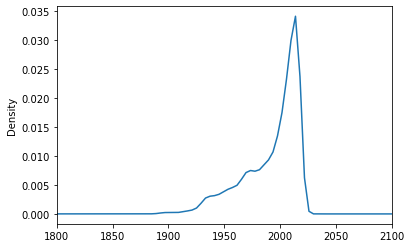

In [40]:
df_year_without_na.plot(kind ='density')
plt.xlim([1800, 2100])
plt.show()

Since it's not simmetric, we decide to fill `na` values with the *median*.

In [41]:
df.year = df.loc[:, 'year'].fillna(np.median(df_year_without_na)).astype('int')

In [42]:
'''
    alternative code in case .fillna is too computationally intensive
'''

# df.to_csv("df_per_fillna.csv", index=False)
# 
# #os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
# os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask
# 
# import dask
# import modin.pandas as pd_mod
# df_temp = pd_mod.read_csv("df_per_fillna.csv")
# df_temp.fillna(value=0)
# df_temp.to_csv("df_without_na.csv")
# df = pd.read_csv("df_without_na.csv")

'\n    alternative code in case .fillna is too computationally intensive\n'

We can check the absence of `Null` or `Na` values.

In [43]:
sum(pd.isna(df).any(axis=1))

0

## Checking duplicates 

There are $643$ duplicated rows.

In [44]:
sum(df.duplicated())

643

We have deleted them by keeping the first.

In [45]:
df.drop_duplicates(inplace=True)

So that, there aren't any duplicated row.

In [46]:
sum(df.duplicated())

0

In [47]:
len(df)

58404

## Binning

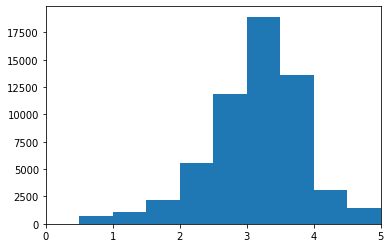

In [48]:
df['rating_mean'].hist(bins=9, grid=False)
plt.xlim([0, 5])
plt.show()

In [49]:
binning = pd.cut(df['rating_mean'], bins=9, labels=False)
df['bin_y'] = binning

## Splitting

In [50]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=20, stratify=df['bin_y'])
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=20, stratify=df_train['bin_y'])

## Smoothing by bin boundaries

### smote

In [51]:
sm = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=50)
X_train, y_train = sm.fit_resample(df_train, df_train['bin_y'])

In [52]:
binning = pd.cut(X_train['rating_mean'], bins=9, labels=False)
binning.value_counts()

3    13029
5    13029
6    13029
2    13029
4    13029
1    13029
8    13029
7    13029
0    13029
Name: rating_mean, dtype: int64

### remove new duplicates

In [53]:
X_train.duplicated().sum()

15801

In [54]:
X_train.drop_duplicates(inplace=True)

In [55]:
X_train.duplicated().sum()

0

### new bins

distribuzione per rating (y continua)

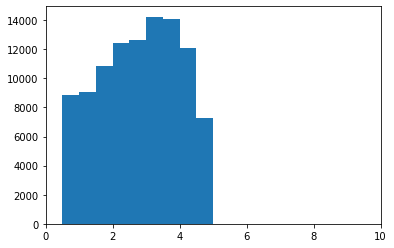

In [56]:
X_train['rating_mean'].hist(bins=9, grid=False)
plt.xlim([0, 10])
plt.show()

distribuzione per bin (y discreta)

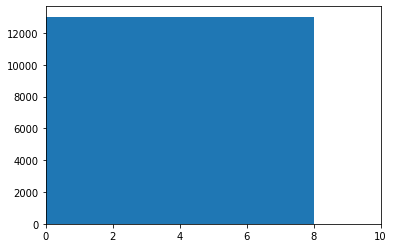

In [57]:
y_train.hist(bins=9, grid=False)
plt.xlim([0, 10])
plt.show()

### set y_train_categorical & y_train_continuos then remove y from X_train

In [58]:
y_train_categorical = X_train['bin_y']
y_train_continuos = X_train['rating_mean']
X_train.drop(columns=['bin_y', 'rating_mean'], axis=1, inplace=True)

y_val_categorical = df_val['bin_y']
y_val_continuous = df_val['rating_mean']
X_val = df_val.drop(columns=['bin_y', 'rating_mean'], axis=1)

y_test_categorical = df_val['bin_y']
y_test_continuous = df_val['rating_mean']
X_test = df_test.drop(columns=['bin_y', 'rating_mean'], axis=1)

## Evaluating standardization

In [59]:
pd.set_option('display.max_rows', df.shape[0]+1)
X_train.describe().loc[['mean', 'min', 'max']]

,year,title_length,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,3d,70mm,80s,9/11,aardman,aardman studios,abortion,absurd,action,action packed,adaptation,adapted from:book,adapted from:comic,adapted from:game,addiction,adolescence,adoption,adultery,adventure,affectionate,afi 100,afi 100 (laughs),afi 100 (movie quotes),africa,afterlife,aging,aids,airplane,airport,alaska,alcatraz,alcoholism,alien,alien invasion,aliens,allegory,almodovar,alone in the world,alter ego,alternate endings,alternate history,alternate reality,alternate universe,amazing cinematography,amazing photography,american civil war,amnesia,amy smart,android(s)/cyborg(s),androids,animal movie,animals,animated,animation,anime,antarctica,anti-hero,anti-semitism,anti-war,apocalypse,archaeology,argentina,arms dealer,arnold,art,art house,artificial intelligence,artist,artistic,artsy,assassin,assassination,assassins,astronauts,atheism,atmospheric,australia,australian,author:alan moore,author:neil gaiman,autism,aviation,awesome,awesome soundtrack,awful,bad,bad acting,bad cgi,bad ending,bad plot,bad science,bad script,bad sequel,ballet,bank robbery,baseball,based on a book,based on a comic,based on a play,based on a true story,based on a tv show,based on a video game,based on book,based on comic,based on true story,basketball,batman,bdsm,beatles,beautiful,beautiful scenery,beautifully filmed,beauty pageant,beer,berlin,best of 2005,best war films,betrayal,better than expected,better than the american version,biblical,big budget,biographical,biography,biopic,birds,biting,bittersweet,bizarre,black and white,black comedy,blaxploitation,bleak,blindness,blood,bloody,boarding school,boat,bollywood,bombs,bond,book,book was better,books,boring,boring!,boston,bowling,boxing,brainwashing,brazil,breathtaking,brilliant,british,british comedy,broadway,brothers,brutal,brutality,buddy movie,bullshit history,bullying,business,c.s. lewis,california,camp,campy,canada,cancer,cannibalism,caper,capitalism,car chase,carrie-anne moss,cars,cartoon,casino,catastrophe,cathartic,catholicism,censorship,cerebral,cgi,character study,chase,cheating,cheerleading,cheesy,chess,chicago,chick flick,child abuse,childhood,children,china,chocolate,chris tucker,christian,christianity,christmas,cia,cinematography,circus,civil war,classic,classic car,classical music,claustrophobic,claymation,clever,clones,cloning,clowns,coen bros,coen brothers,cold war,college,colonialism,colourful,comedy,comic,comic book,comic book adaption,comics,coming of age,coming-of-age,communism,compassionate,competition,complex,complex characters,complicated,complicated plot,computer animation,computer game,computers,con artists,con men,confrontational,confusing,conspiracy,conspiracy theory,controversial,cooking,cool,corny,corporate america,corruption,costume drama,courage,court,courtroom,courtroom drama,crappy sequel,crazy,creativity,creepy,crime,crime gone awry,criterion,cross dressing,crude humor,cuba,cult,cult classic,cult film,culture clash,cute,cute!,cyberpunk,cyborgs,cynical,dance,dancing,dark,dark comedy,dark fantasy,dark hero,dark humor,dc comics,deadpan,death,death penalty,demons,depp & burton,depressing,depression,desert,destiny,detective,devil,dialogue,dialogue driven,dinosaurs,directorial debut,disability,disappointing,disaster,disney,disney animated feature,distopia,disturbing,divorce,doctors,documentary,dog,dogs,dolphins,downbeat,dr. seuss,dragon,dragons,drama,dramatic,dreamlike,dreams,dreamworks,drinking,drug abuse,drug addiction,drugs,dumb,dumb but funny,dynamic cgi action,dysfunctional family,dystopia,dystopic future,earnest,easily confused with other movie(s) (title),east germany,eccentricity,ecology,educational,eerie,effects,egypt,emma watson,emotional,end of the world,england,enigmatic,ennio morricone,enormously long battle scene,ensemble c

The genres columns have `0` or `1` as values.\
We have evaluating the feasibility of the standardization over relevance tags by plotting the distribution.

Since the number of tags is too high, we have plotted the distribution of only 12 randomly sampled tags. 

In [60]:
len(X_train.iloc[:,22:-2].columns)

1126

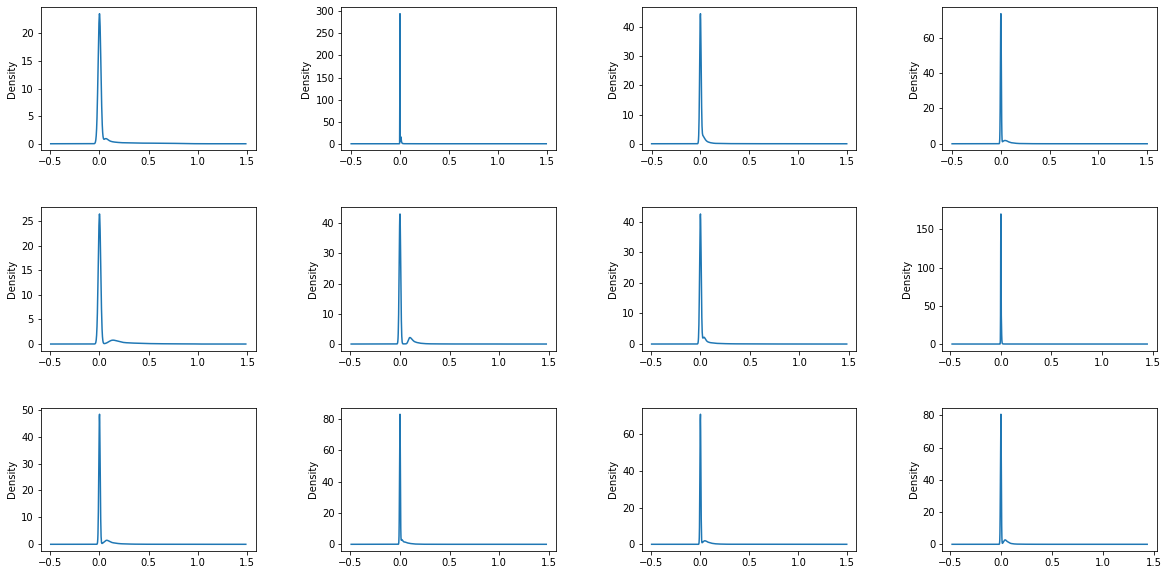

In [61]:
# columns_sampled = np.random.choice(df.iloc[:,21:-2].columns, 12, replace=False)
# 
# fig = plt.figure(figsize = (20,10))
# fig.subplots_adjust(hspace=0.4, wspace=0.4)
# for i in np.arange(1,13):
#     ax = fig.add_subplot(3, 4, i)
#     X_train[columns_sampled[i-1]].plot(kind ='density')
# plt.show()

Since it turns out that distributions aren't gaussian, we have excluded the standardization: the min-max scaling is pointless as values are already scaled between 0 and 1.  

Regarding the `title_legth` feature, we plot its distribution to evaluate the feasibility of the standardization.

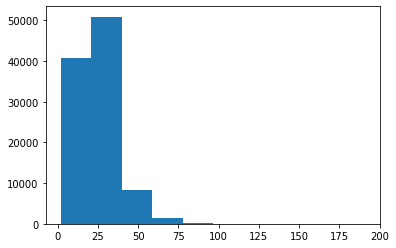

In [62]:
X_train['title_length'].hist(bins=10, grid=False)
plt.show()

Such distribution is not gaussian therefore we end up to apply *min-max scaling* in order to scale values in the range [0,1].

In [63]:
X_train_minmaxscaled = X_train.copy()
X_val_minmaxscaled = X_val.copy()
X_test_minmaxscaled = X_test.copy()

In [64]:
title_length_train_min = np.min(X_train['title_length'])
title_length_train_max = np.max(X_train['title_length'])
title_length_train_range = title_length_train_max - title_length_train_min

X_train_minmaxscaled['title_length'] = (X_train['title_length'] - title_length_train_min) / title_length_train_range
X_val_minmaxscaled['title_length'] = (X_val['title_length'] - title_length_train_min) / title_length_train_range
X_test_minmaxscaled['title_length'] = (X_test['title_length'] - title_length_train_min) / title_length_train_range

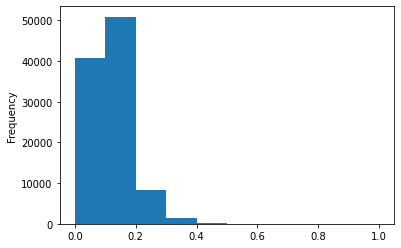

In [65]:
X_train_minmaxscaled['title_length'].plot(kind ='hist')
plt.show()

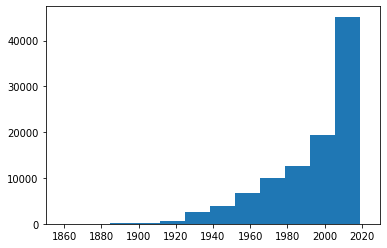

In [66]:
X_train['year'].hist(bins=150, grid=False)
plt.xlim([1850, 2030])
plt.show()

In [67]:
year_train_min = np.min(X_train['year'])
year_train_max = np.max(X_train['year'])
year_train_range = year_train_max - year_train_min

X_train_minmaxscaled['year'] = (X_train['year'] - year_train_min) / year_train_range
X_val_minmaxscaled['year'] = (X_val['year'] - year_train_min) / year_train_range
X_test_minmaxscaled['year'] = (X_test['year'] - year_train_min) / year_train_range

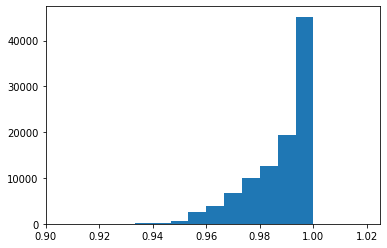

In [68]:
X_train_minmaxscaled['year'].hist(bins=150, grid=False)
plt.xlim([0.9, 1.025])
plt.show()

In [69]:
X_train['ratings_count'].loc[X_train['ratings_count']> 80000]

9467    81491
Name: ratings_count, dtype: int32

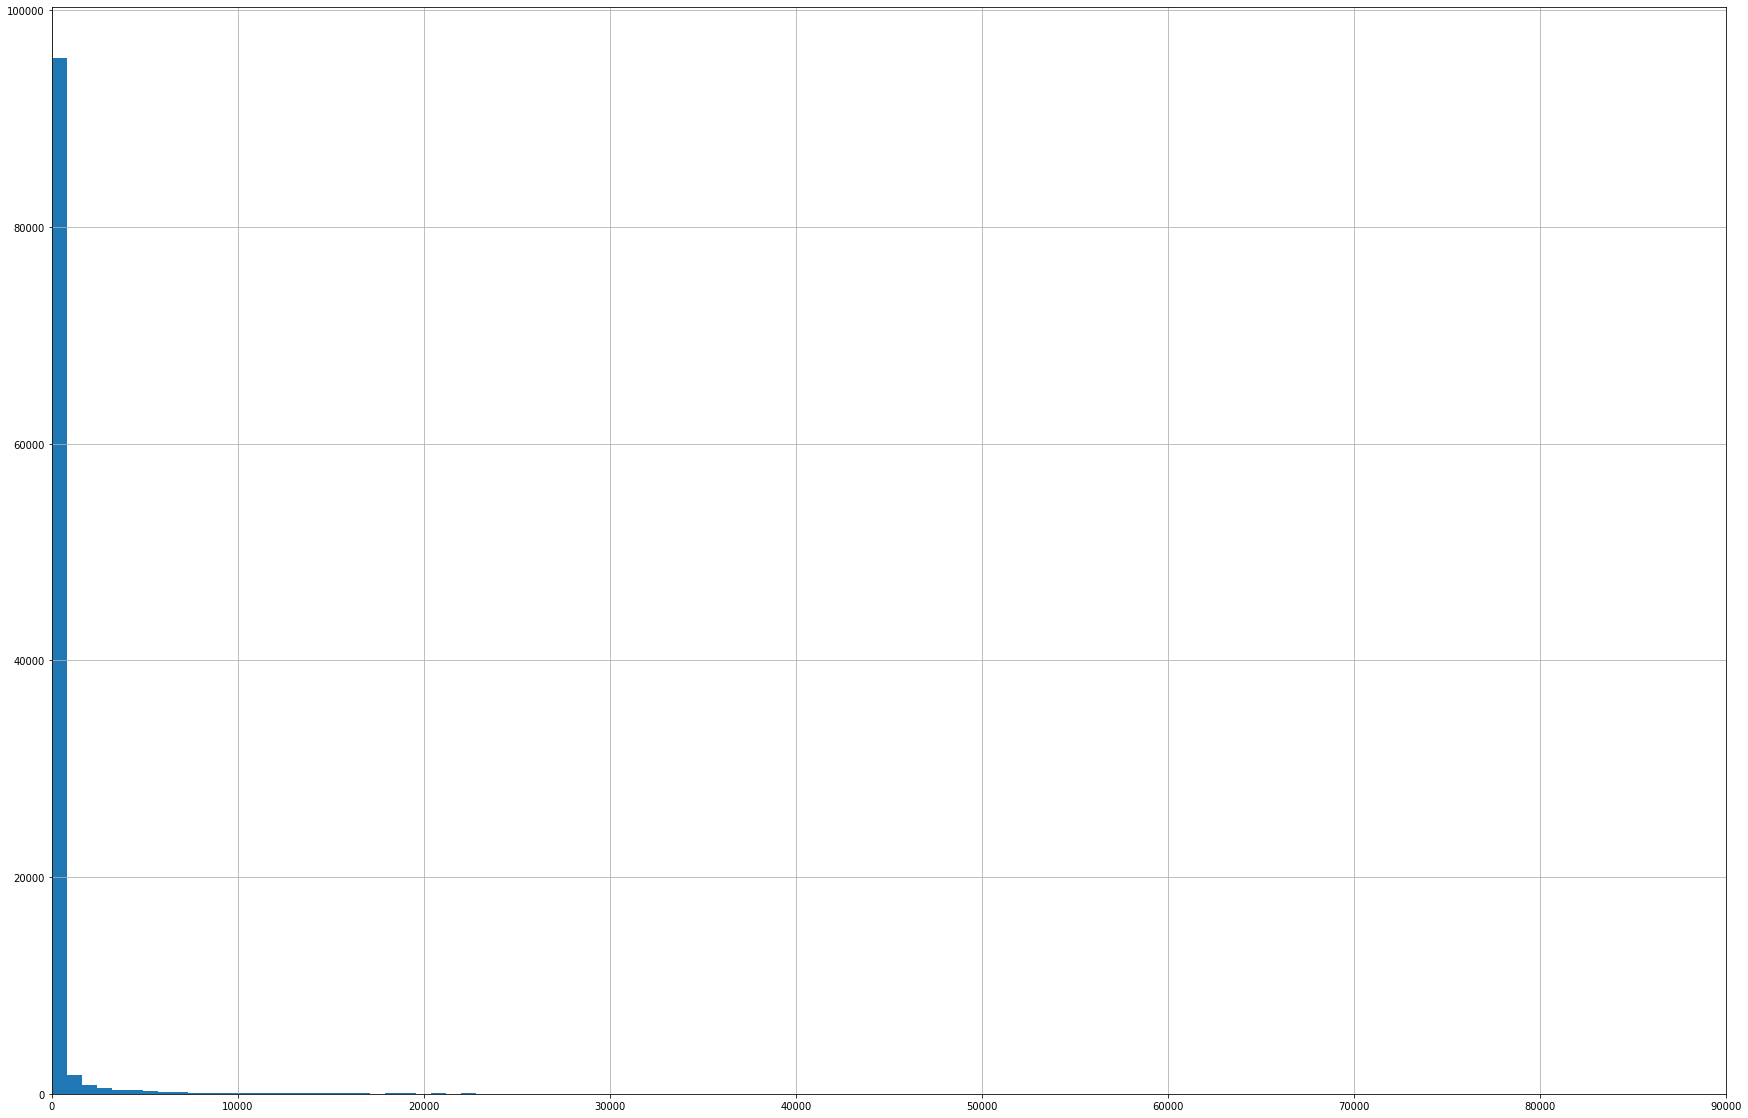

In [70]:
X_train['ratings_count'].hist(bins=100, figsize=(30,20))
plt.xlim([0, 90000])
plt.show()

In [71]:
ratings_count_train_min = np.min(X_train['ratings_count'])
ratings_count_train_max = np.max(X_train['ratings_count'])
ratings_count_train_range = ratings_count_train_max - ratings_count_train_min

X_train_minmaxscaled['ratings_count'] = (X_train['ratings_count'] - ratings_count_train_min) / ratings_count_train_range
X_val_minmaxscaled['ratings_count'] = (X_val['ratings_count'] - ratings_count_train_min) / ratings_count_train_range
X_test_minmaxscaled['ratings_count'] = (X_test['ratings_count'] - ratings_count_train_min) / ratings_count_train_range

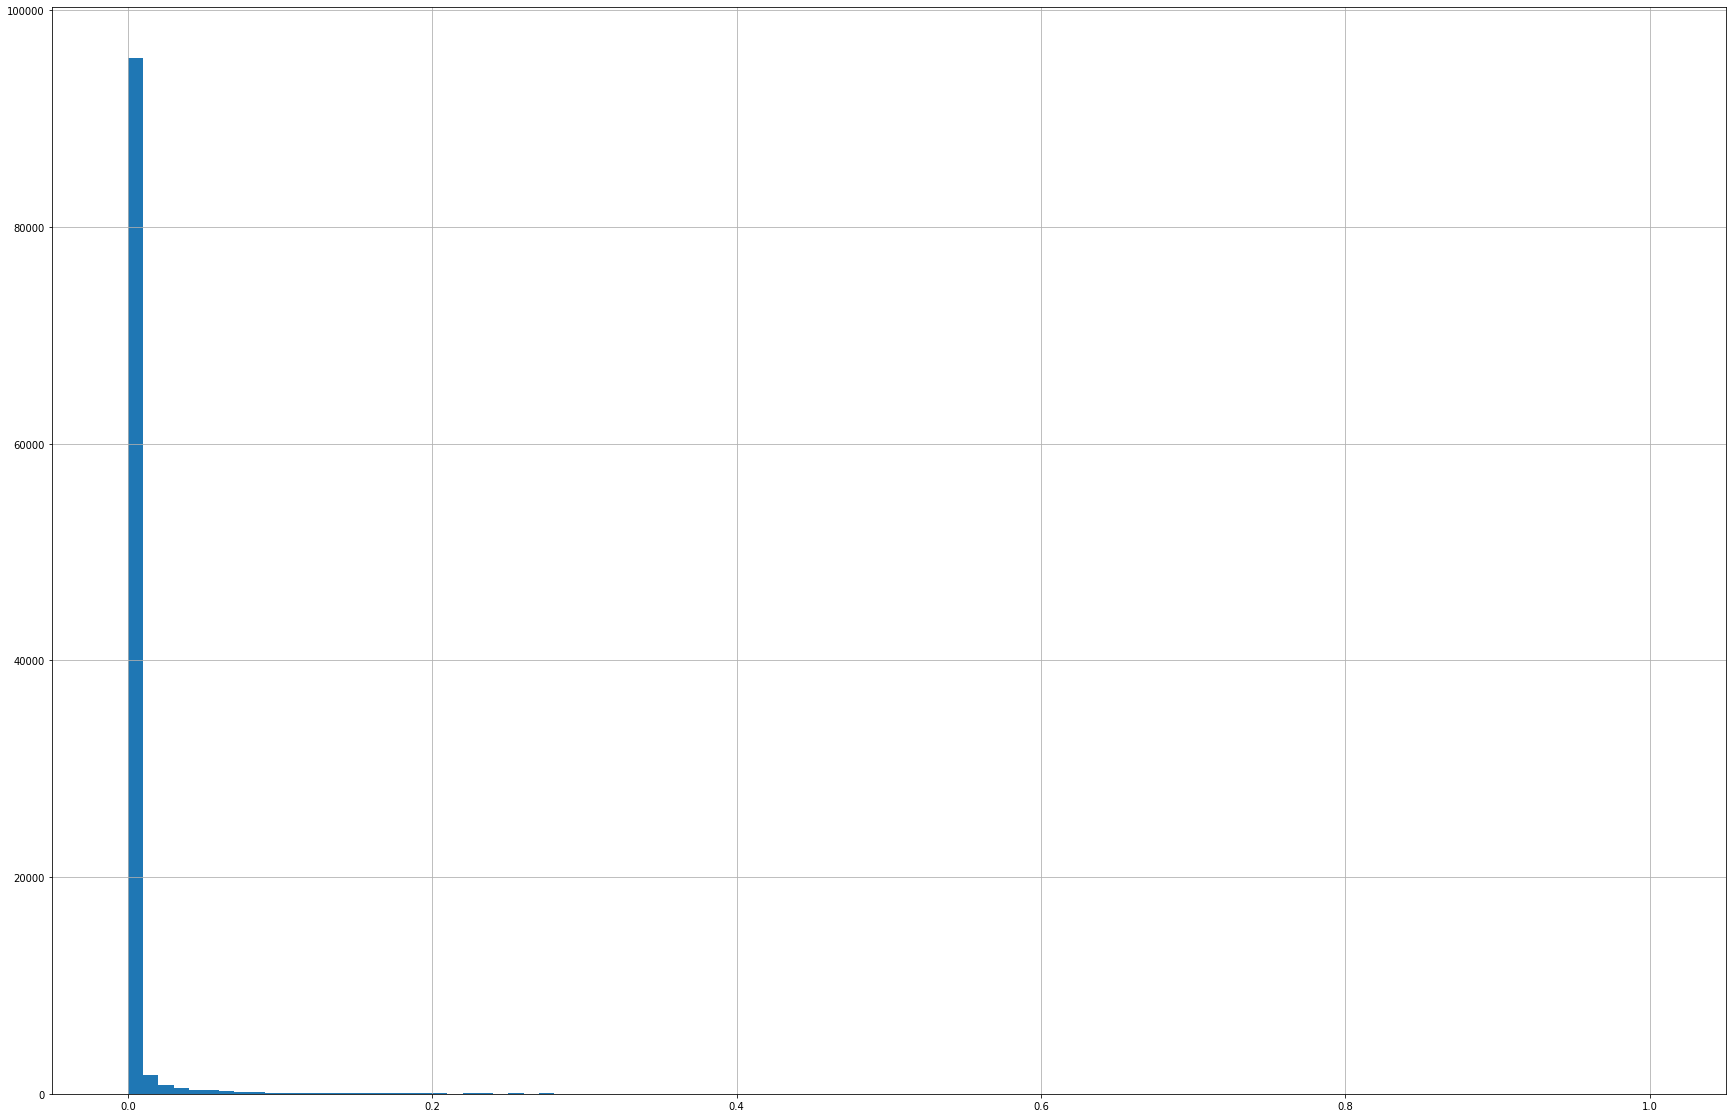

In [72]:
X_train_minmaxscaled['ratings_count'].hist(bins=100, figsize=(30,20))
plt.show()

In [73]:
len(X_train)

101460

## Evaluating normalization

L2 normalization is applied to each observation so the that the values in a row have a unit norm. Unit norm with L2 means that if each element were squared and summed, the total would equal 1

In [74]:
X_train_normalized_l2 = X_train.copy()
X_train_normalized_l2.iloc[:,:] = normalize(X_train, norm='l2')

# alternative code in slides
# x_norm2 = np.linalg.norm(x, ord=2)
# x_normalized = x / x_norm2

In [75]:
X_train_normalized_l1 = X_train.copy()
X_train_normalized_l1.iloc[:,:] = normalize(X_train, norm='l1')

In [76]:
X_train_normalized_lmax = X_train.copy()
X_train_normalized_lmax.iloc[:,:] = normalize(X_train, norm='max')

In [77]:
X_train_normalized_SSRN = X_train.copy()
X_train_normalized_SSRN.iloc[:,:] = np.sign(X_train)*np.sqrt(np.abs(X_train))

In [78]:
X_train_minmaxscaled_normalized_SSRN = X_train.copy()
X_train_minmaxscaled_normalized_SSRN.iloc[:,:] = np.sign(X_train_minmaxscaled)*np.sqrt(np.abs(X_train_minmaxscaled))

In [79]:
X_train.iloc[:,:4].describe().loc[['mean', 'min', 'max']]

,year,title_length,Action,Adventure
mean,1993.610369,25.075636,0.062961,0.031313
min,6.000000,2.000000,0.000000,0.000000
max,2019.000000,191.000000,1.000000,1.000000


In [80]:
display_side_by_side(
    [
        X_train_normalized_l2.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
        X_train_normalized_l1.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
        X_train_normalized_lmax.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
        X_train_minmaxscaled.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
        X_train_normalized_SSRN.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
        X_train_minmaxscaled_normalized_SSRN.iloc[:,:4].describe().loc[['mean', 'min', 'max']]
    ],
    [
        "X_train_normalized_l2",
        "X_train_normalized_l1",
        "X_train_normalized_lmax",
        "X_train_minmaxscaled",
        "X_train_normalized_SSRN",
        "X_train_minmaxscaled_normalized_SSRN"
    ])

,year,title_length,Action,Adventure
mean,0.971200,0.012214,0.000029,0.000014
min,0.024462,0.000233,0.000000,0.000000
max,0.999998,0.301511,0.000529,0.000526
,year,title_length,Action,Adventure
mean,0.934228,0.011705,0.000028,0.000013
min,0.023812,0.000227,0.000000,0.000000
max,0.997510,0.200000,0.000521,0.000518
,year,title_length,Action,Adventure
mean,0.978058,0.012303,0.000030,0.000014
min,0.024469,0.000233,0.000000,0.000000


# DATA MODELING

In [81]:
X_train_minmaxscaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101460 entries, 0 to 117255
Columns: 1150 entries, year to ratings_count
dtypes: float64(1131), int32(19)
memory usage: 883.6 MB


In [82]:
fcols = X_train_minmaxscaled.select_dtypes('float').columns
icols = X_train_minmaxscaled.select_dtypes('integer').columns

X_train_minmaxscaled[fcols] = X_train_minmaxscaled[fcols].apply(pd.to_numeric, downcast='float')
X_train_minmaxscaled[icols] = X_train_minmaxscaled[icols].apply(pd.to_numeric, downcast='integer')

In [ ]:
X_train_minmaxscaled.info()

## SVM
### Hamming

We want to measure distances between samples by separately considering tags and genres: by the way, we have created two new columns:
- `genres` which collapses in a list the values corresponding to genres' columns;
- `tags` which collapses in a list the values corresponding to tags' columns.

In [ ]:
df_movies['genres'] = df_movies.iloc[:,3:23].values.tolist()

In [ ]:
# np.sum(np.bitwise_xor([1,1,0,0,0],[1,0,1,1,0]))

[] Normalizzazione (valtare se serve stampando distanze tra campioni)\
[] SVM regressione e custom kernel

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bf1ffefd-829c-4106-9d06-fc92ae4df2dd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>